In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [36]:
varinfo.X_m = dict(bins=(0,2000,30))
varinfo.Y_m = dict(bins=(0,1500,30))
varinfo.HX_m = dict(bins=(0,300,30))
varinfo.H1_m = dict(bins=(0,300,30))
varinfo.H2_m = dict(bins=(0,300,30))

In [7]:
re_mxmy = re.compile(r'.*MX-(\d+)_MY-(\d+).*')
def get_mxmy(fname):
    m = re_mxmy.match(fname)
    if m:
        return int(m.group(1)), int(m.group(2))
    return None

In [4]:
fc.sixb = fc.FileCollection('/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag_4b/')
f_signal = np.array([ f'{d}/ntuple.root' for d in fc.sixb.Official_NMSSM.ls if d.endswith('pythia8') ])
f_qcd = fc.sixb.QCD_B_List

In [15]:
masses = np.array(list(map(get_mxmy, f_signal)))
selected = np.where(np.all(masses == np.array([1000,450]), axis=1))[0]

In [57]:
selected = np.array([
    [700,300],
    [1000,450],
    [1400,600],
])

selected = np.argmax((1000*masses[:,0] + masses[:,1]) == (1000*selected[:,0] + selected[:,1])[:,None], axis=1)

In [58]:
signal = ObjIter([Tree([f], report=False) for f in tqdm(f_signal[selected])])
bkg = ObjIter([Tree(f_qcd)])

100%|██████████| 16/16 [00:09<00:00,  1.60it/s]


In [60]:
signal.mx

[700, 1000, 1400]

In [61]:
def build_mass_bkg(sigtree, bkg):
    mass_bkg = bkg.copy()
    mass_bkg.apply(lambda t : t.extend(gen_X_m=sigtree.mx*np.ones(len(t)), gen_Y_m=sigtree.my*np.ones(len(t))))
    return mass_bkg

mass_bkg = signal.apply(lambda t : build_mass_bkg(t, bkg))

In [71]:
mass_bkg.flat

[<utils.classUtils.Tree.CopyTree object at 0x7f02be2df160>, <utils.classUtils.Tree.CopyTree object at 0x7f02be2dadf0>, <utils.classUtils.Tree.CopyTree object at 0x7f02be2dadc0>]

In [73]:
modelpath = '/eos/uscms/store/user/ekoenig/weaver/models/exp_parametric/parametric_feynnet_ranker_6b/20230726_7b26c7942de5460f2a073c57fabb5de9_ranger_lr0.0047_batch2000_withbkg'

load_para_feynnet = sixb.f_load_feynnet_assignment(modelpath, onnx=True)

import multiprocess as mpl

with mpl.Pool(8) as pool:
    (signal+mass_bkg.flat).parallel_apply(load_para_feynnet, pool=pool, report=True)
    
(signal+mass_bkg.flat).apply(sixb.assign)

f_load_feynnet_assignment: 100%|██████████| 6/6 [01:18<00:00, 13.00s/it]


[None, None, None, None, None, None]

100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


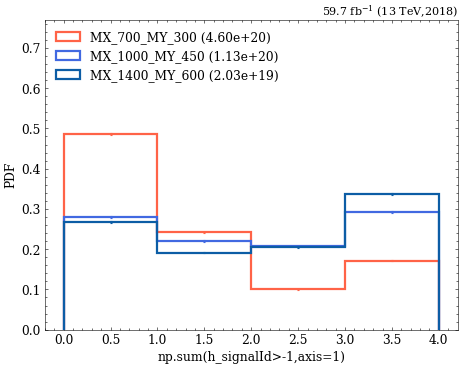

In [79]:
study.quick(
    signal,
    varlist=['np.sum(h_signalId>-1,axis=1)',],
    efficiency=True,
    legend=True,
)

100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


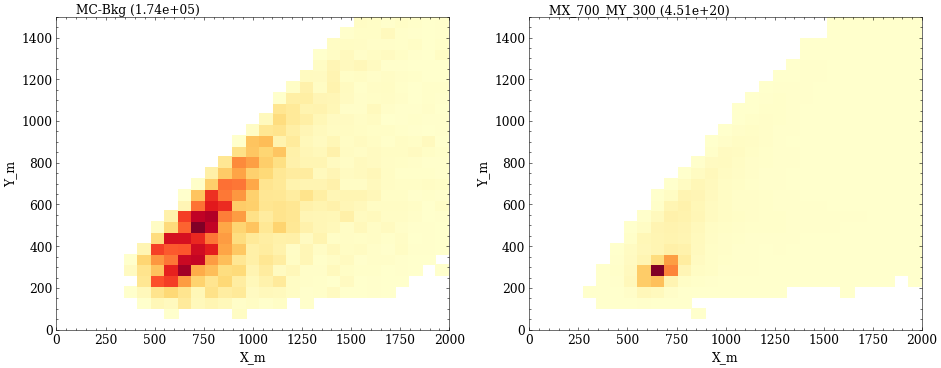

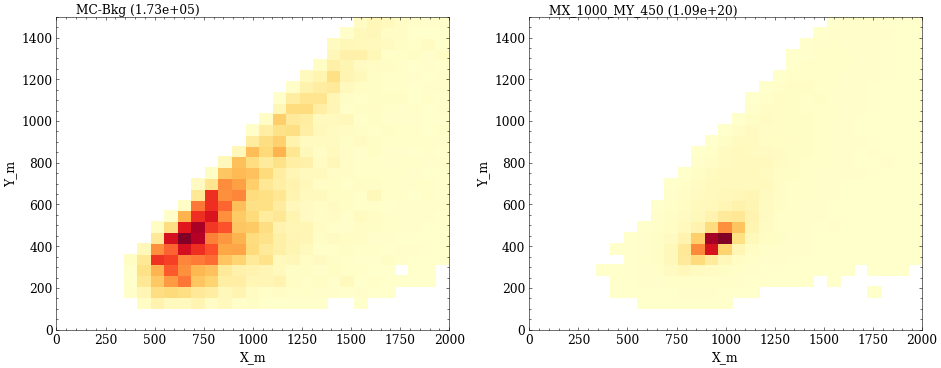

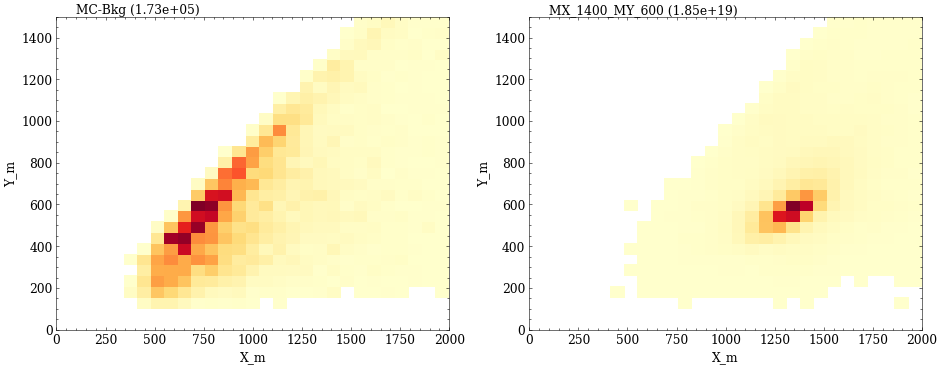

In [89]:
for sigtree, bkg in zip(signal, mass_bkg):
    trees = ObjIter([sigtree]) + bkg
    study.quick2d(
        trees,
        varlist=['X_m','Y_m'],
        efficiency=True,
        legend=True,
    )

100%|██████████| 6/6 [00:00<00:00,  6.93it/s]


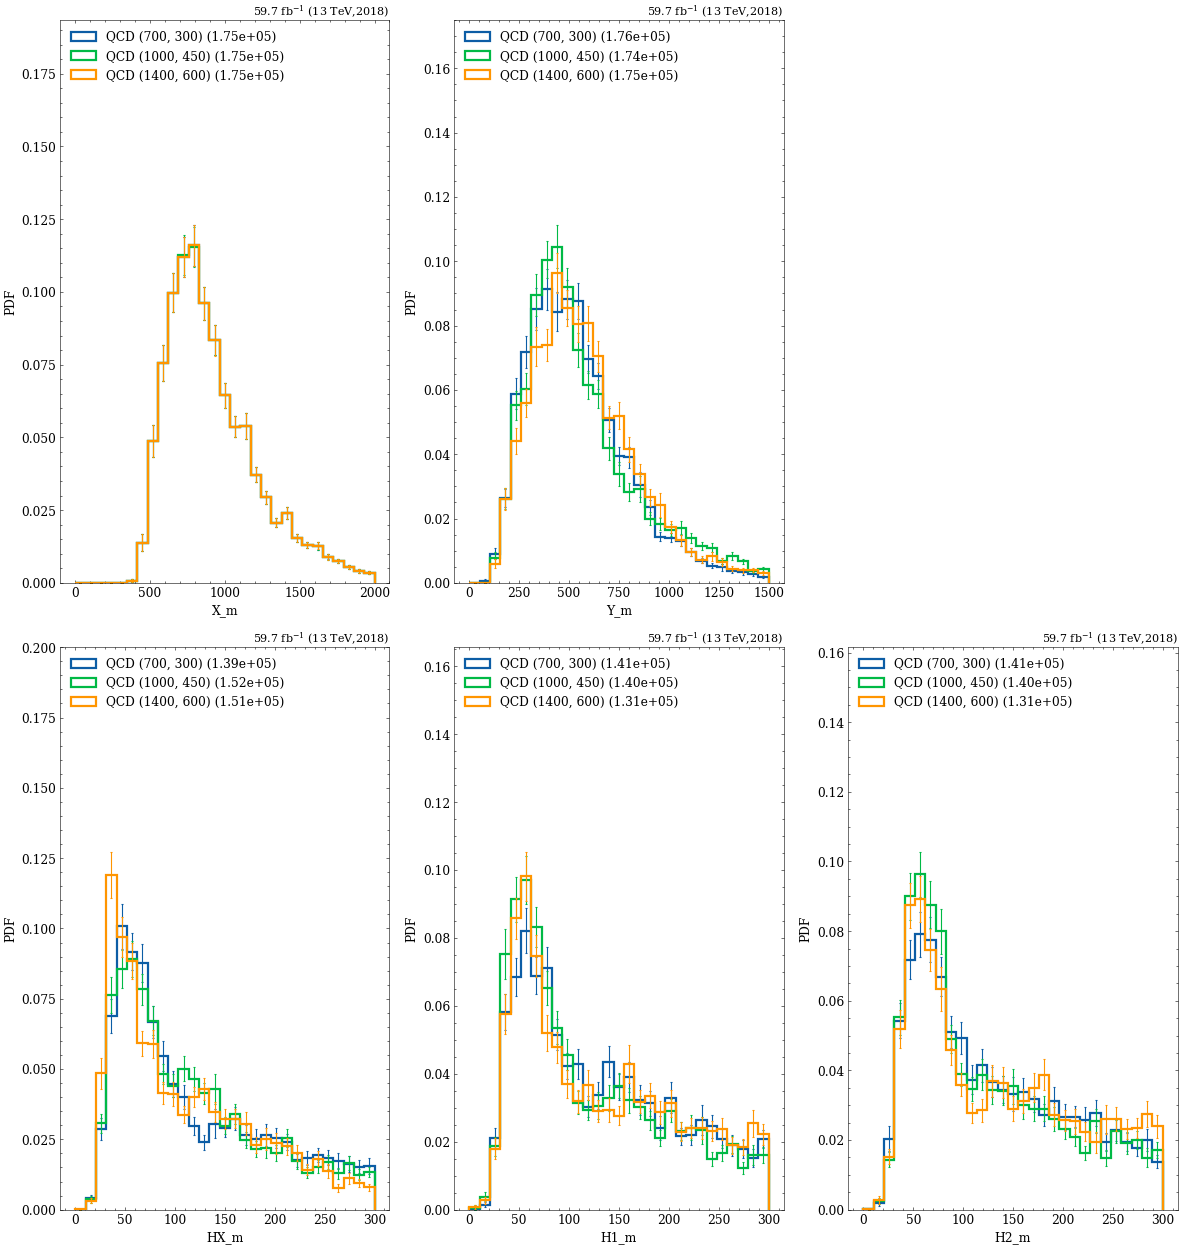

In [131]:
study.quick(
    mass_bkg.flat, stacked=False,
    h_label=[ f'QCD {mass}' for mass in signal.mass.list ], 
    h_color=None,
    varlist=['X_m','Y_m',None,'HX_m','H1_m','H2_m'],
    efficiency=True,
    legend=True,
    size=(5,8)
)

In [112]:
def random_h_m(t):
    h_m = t.h_m
    randperm = ak.from_regular(np.random.uniform(size=(len(t),3)).argsort(axis=1))
    t.extend(rand_h_m=h_m[randperm])

(signal+mass_bkg.flat).apply(random_h_m,report=True)


random_h_m: 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


[None, None, None, None, None, None]

100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


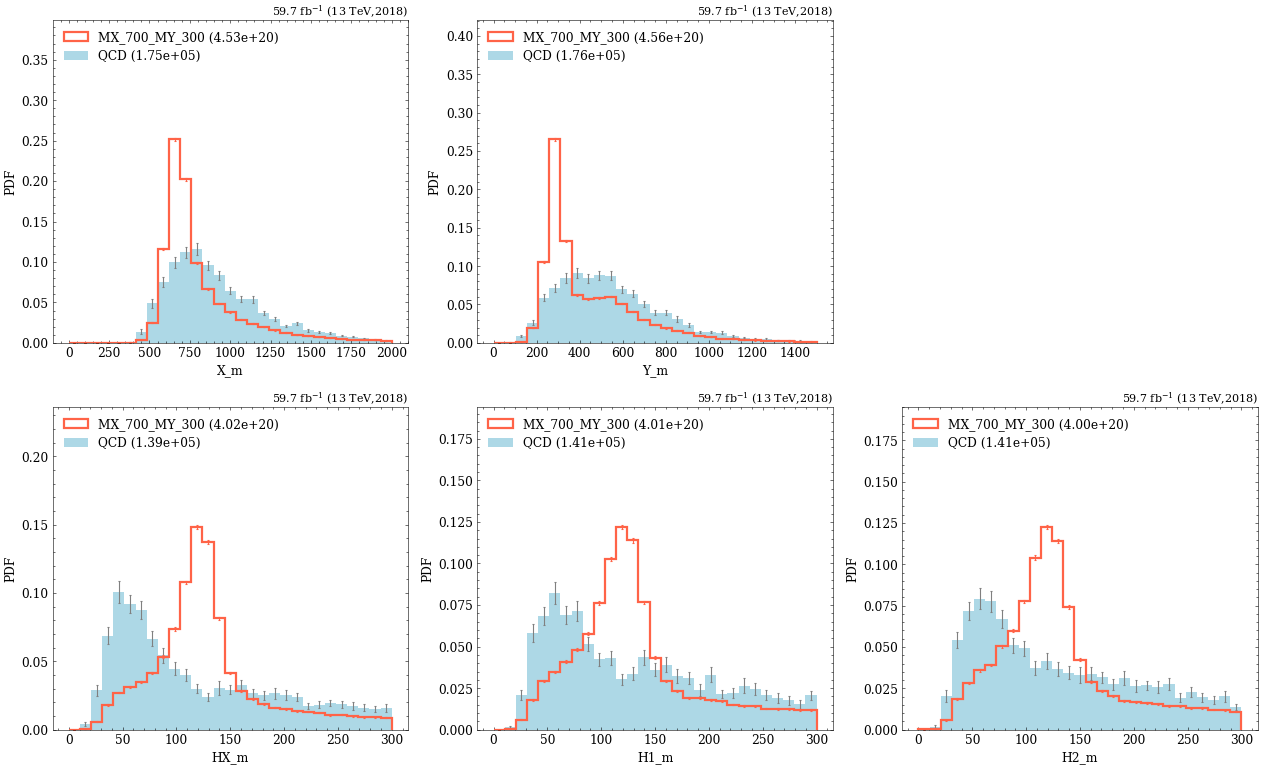

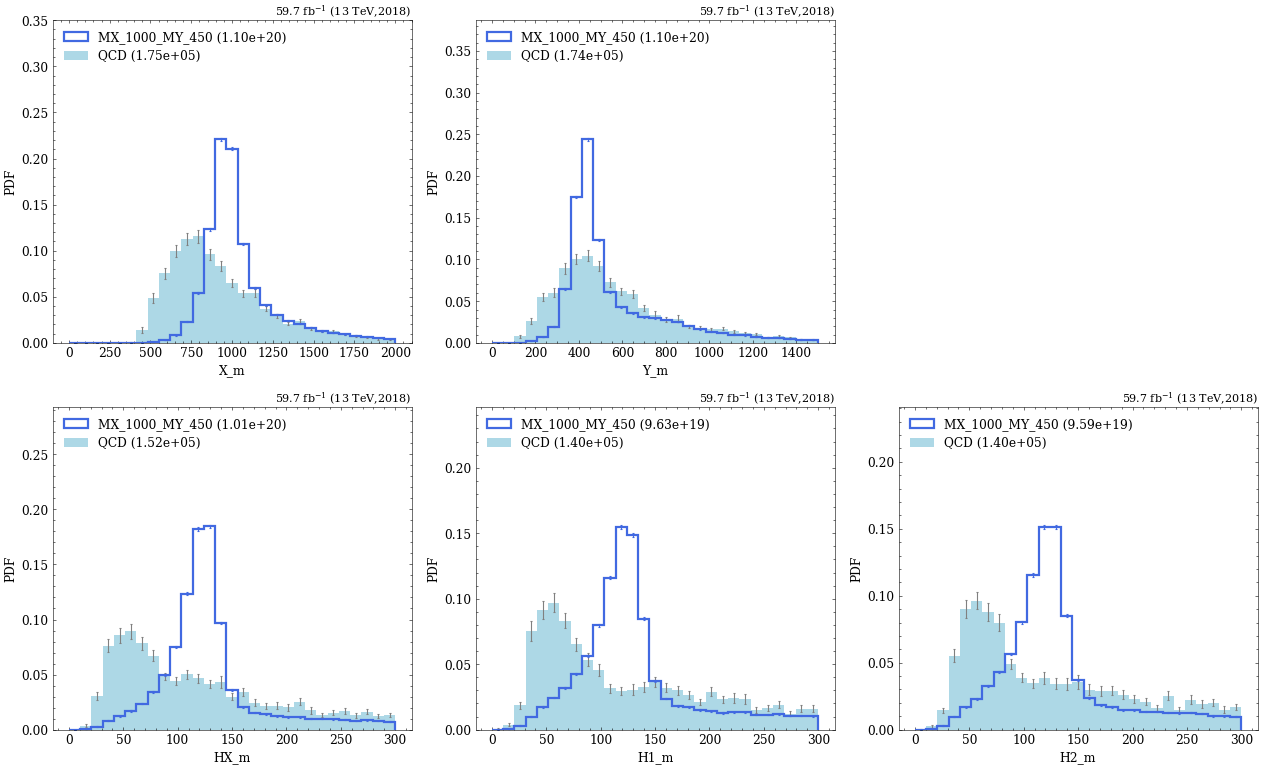

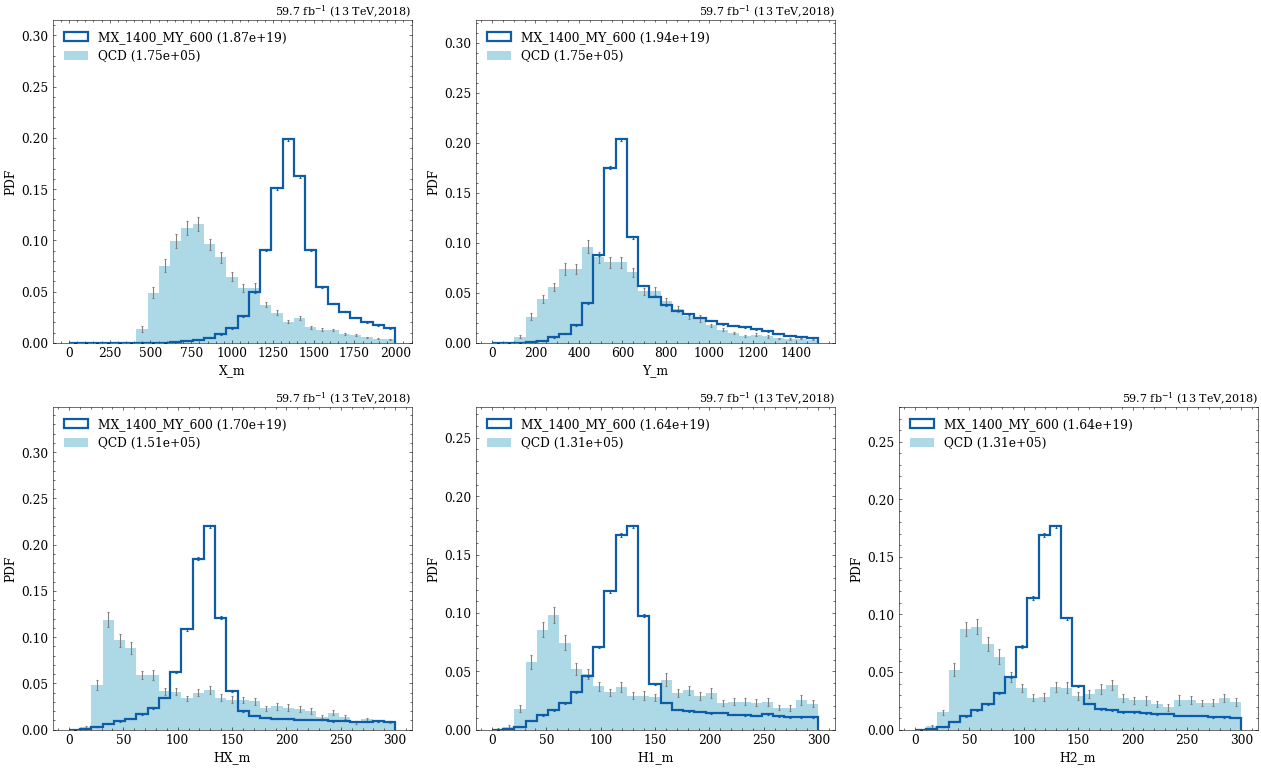

In [132]:
for sigtree, bkg in zip(signal, mass_bkg):
    trees = ObjIter([sigtree]) + bkg
    study.quick(
        trees,
        varlist=['X_m','Y_m',None,'HX_m','H1_m','H2_m'],
        # binlist=[(0,300,30)]*3,
        efficiency=True,
        legend=True,
    )

100%|██████████| 6/6 [00:01<00:00,  3.84it/s]


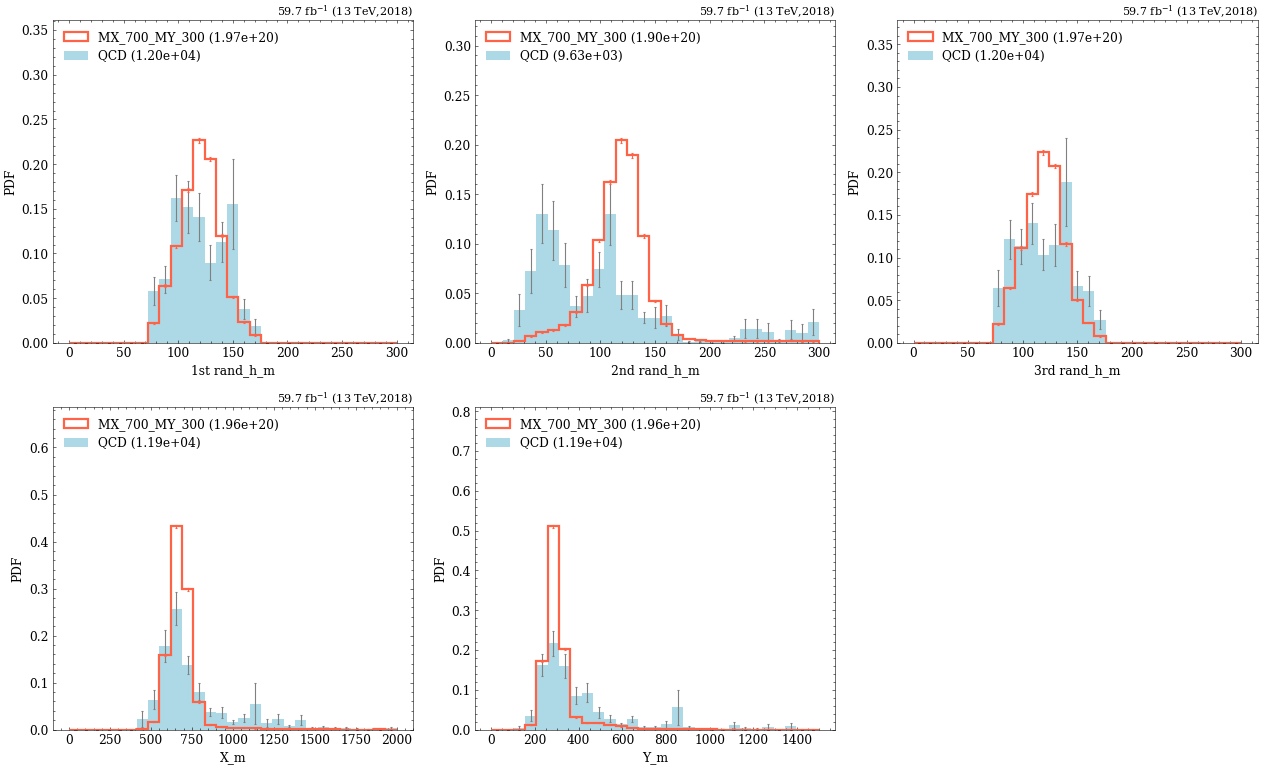

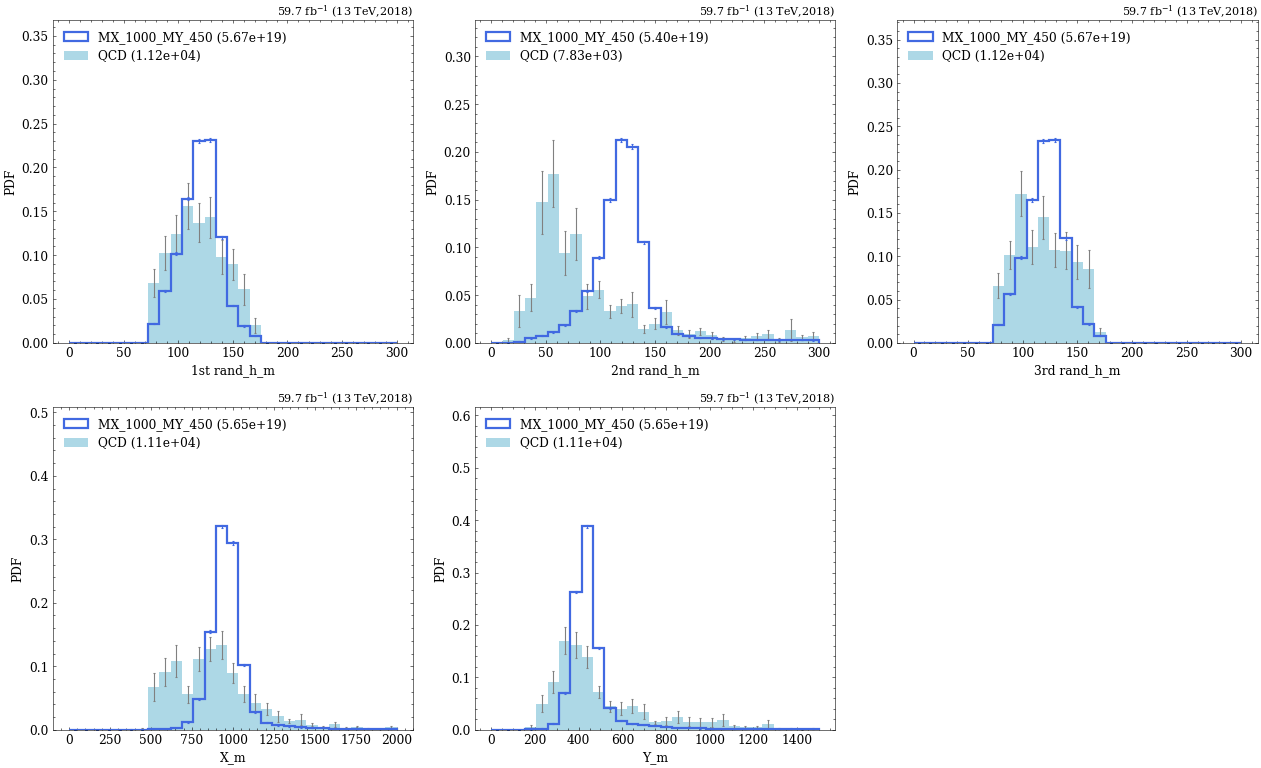

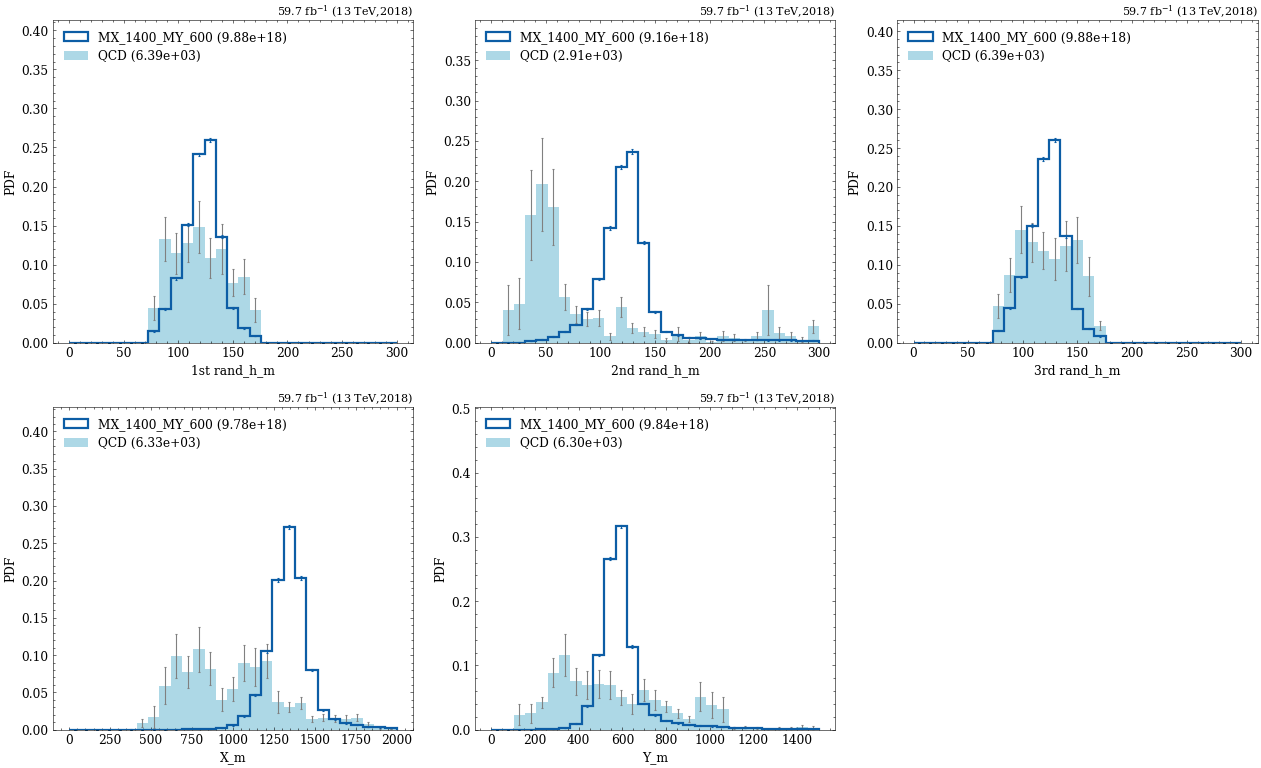

In [133]:
for sigtree, bkg in zip(signal, mass_bkg):
    trees = ObjIter([sigtree]) + bkg
    study.quick(
        trees,
        masks=lambda t : np.sum((t.rand_h_m[:,[0,2]]-125)**2, axis=1) < 50**2,
        varlist=[f'rand_h_m[:,{i}]' for i in range(3)]+['X_m','Y_m',None],
        binlist=[(0,300,30)]*3,
        h_rebin=30,
        efficiency=True,
        legend=True,
    )